In [1]:
%load_ext autoreload
%autoreload 2
import os

while not os.getcwd().endswith("naml_exams"):
    os.chdir("..")

# Exercise 1


In [ ]:
from matplotlib.image import imread
import matplotlib.pyplot as plt
import numpy as np
import os

plt.rcParams["figure.figsize"] = [16, 8]

Load the image of a dog:


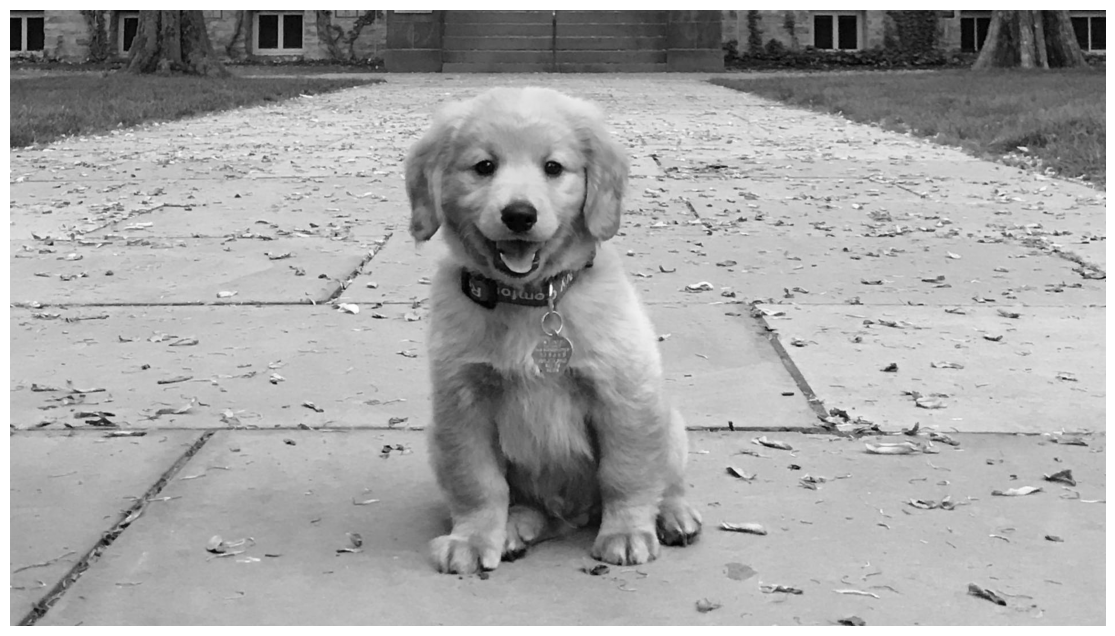

In [ ]:
A = imread(os.path.join(".", "data/dog.jpg"))
X = np.mean(A, -1)  # Convert RGB to grayscale
img = plt.imshow(X)
img.set_cmap("gray")
plt.axis("off")
plt.show()

Compute the economy SVD


In [4]:
U, s, VT = np.linalg.svd(A, full_matrices=False)
U.shape, s.shape, VT.shape

((1080, 1920, 3), (1080, 3), (1080, 3, 3))

Let $\mathbf{X}$ be the matrix representing the true image and $\tilde{\mathbf{X}}$ the approximation of rank $r$ obtained using the SVD. Compute and plot the relative reconstruction error of the truncated SVD in the Frobenius norm as a function of the rank r. The expression of the relative reconstruction error is given by:

$$
\frac{\lVert \mathbf{X} - \tilde{\mathbf{X}} \rVert_F}{\lVert \mathbf{X} \rVert_F}
$$


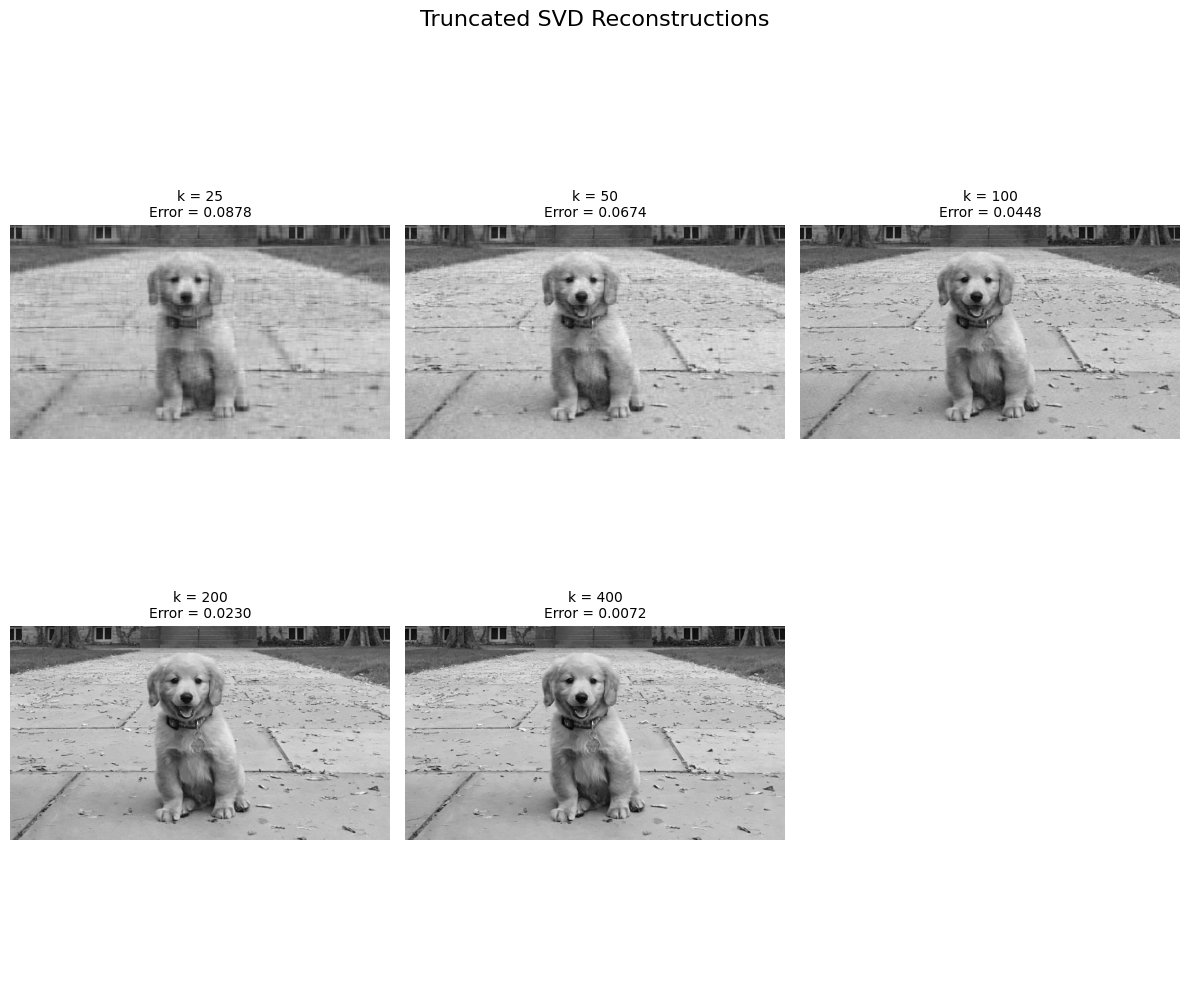

In [5]:
ks = [25, 50, 100, 200, 400]
recon_error = []

# Perform SVD once
U, s, VT = np.linalg.svd(X, full_matrices=False)

# Create 3x2 subplot grid
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 10))
axs = axs.flatten()  # Flatten to access via a single index

for i, k in enumerate(ks):
    # Truncate SVD to rank-k
    Xk = U[:, :k] @ np.diag(s[:k]) @ VT[:k, :]

    # Compute reconstruction error
    error = np.linalg.norm(X - Xk, ord="fro") / np.linalg.norm(X, ord="fro")
    recon_error.append(error)

    # Plot image
    axs[i].imshow(Xk, cmap="gray")
    axs[i].set_title(f"k = {k}\nError = {error:.4f}", fontsize=10)
    axs[i].axis("off")

# Turn off any unused subplot (like the 6th one in this case)
for j in range(len(ks), len(axs)):
    axs[j].axis("off")

# Add a main title and layout adjustments
fig.suptitle("Truncated SVD Reconstructions", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Square this error (and plot it) to compute the fraction of the missing variance as a function of r;


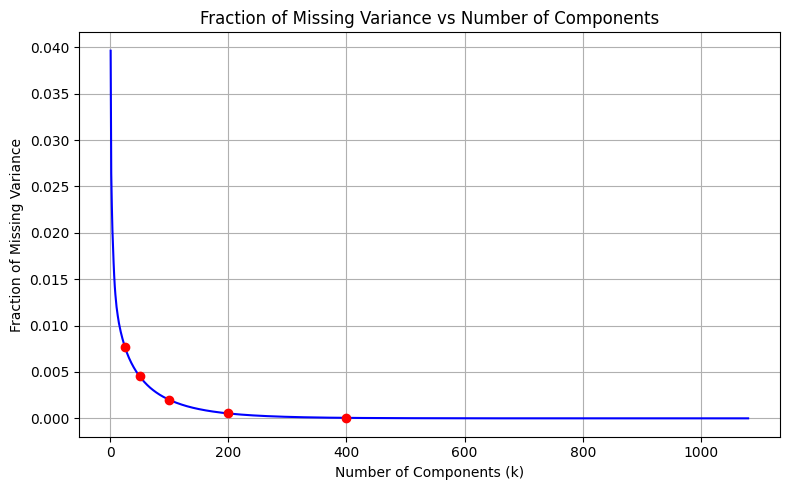

In [ ]:
# Compute cumulative explained variance
total_variance = np.sum(s**2)
explained_variance = np.cumsum(s**2)
missing_variance = (
    1 - explained_variance / total_variance
)  # Fraction of missing variance

# Plot full curve
plt.figure(figsize=(8, 5))
plt.plot(
    np.arange(1, len(s) + 1), missing_variance, label="Missing Variance", color="blue"
)

# Highlight selected ks
for k in ks:
    plt.scatter(k, missing_variance[k - 1], color="red", zorder=5)

plt.title("Fraction of Missing Variance vs Number of Components")
plt.xlabel("Number of Components (k)")
plt.ylabel("Fraction of Missing Variance")
plt.grid(True)
plt.tight_layout()
plt.show()

Find the rank $r_v$ where the reconstruction captures 99% of the total variance;


Rank r_v capturing 99% variance: 16
Reconstruction error with rv components: 0.0997


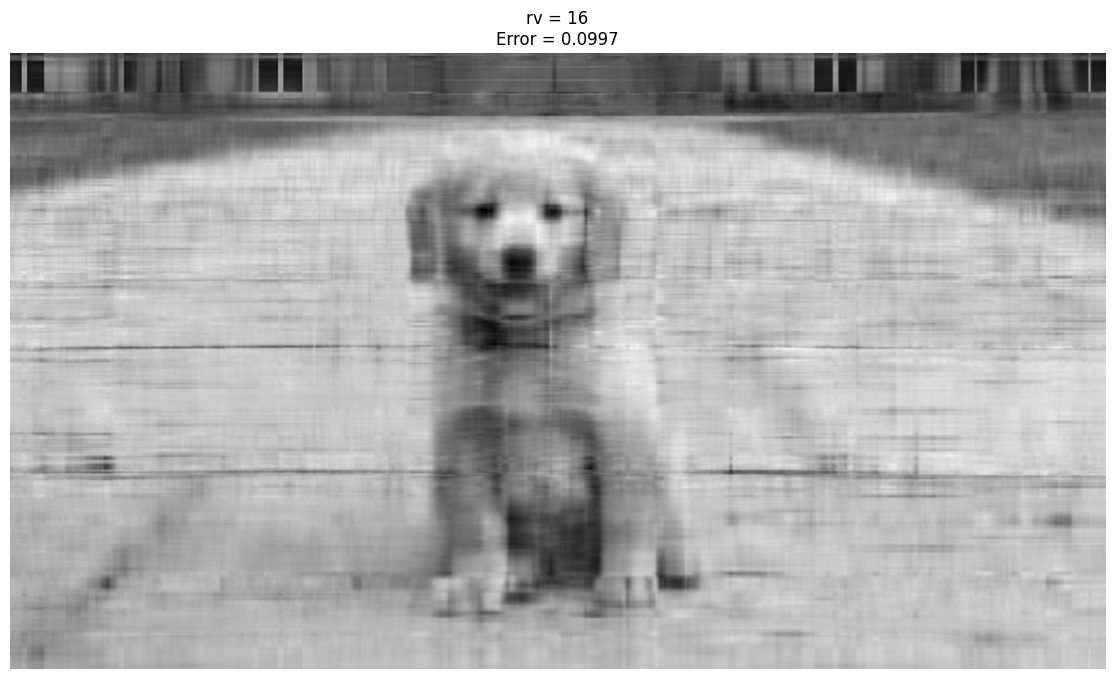

In [18]:
explained_variance_ratio = explained_variance / total_variance
rv = np.argmax(explained_variance_ratio >= 0.99) + 1
print(f"Rank r_v capturing 99% variance: {rv}")

# Reconstruct using rv components
X_rv = U[:, :rv] @ np.diag(s[:rv]) @ VT[:rv, :]

# Compute reconstruction error
error = np.linalg.norm(X - X_rv, ord="fro") / np.linalg.norm(X, ord="fro")
print(f"Reconstruction error with rv components: {error:.4f}")

# Plot reconstructed image
plt.imshow(X_rv, cmap="gray")
plt.title(f"rv = {rv}\nError = {error:.4f}")
plt.axis("off")
plt.show()

Compare $r_v$ with the rank $r_F$ where the reconstruction captures 99% in the Frobenius norm and with the rank $r_c$ that captures 99% of the cumulative sum of singular values.


In [ ]:
total_variance = np.sum(s**2)
explained_variance = np.cumsum(s**2)
explained_variance_ratio = explained_variance / total_variance

total_singular_sum = np.sum(s)
cumulative_singular_sum = np.cumsum(s)

# Compute rv: 99% variance captured (using squared singular values)
rv = np.argmax(explained_variance_ratio >= 0.99) + 1

# Compute rc: 99% cumulative singular values captured (using singular values)
rc = np.argmax(cumulative_singular_sum / total_singular_sum >= 0.99) + 1

# Compute rF: smallest rank with reconstruction error ≤ 0.01 (1%)
fro_errors = []
for k in range(1, len(s) + 1):
    Xk = U[:, :k] @ np.diag(s[:k]) @ VT[:k, :]
    rel_error = np.linalg.norm(X - Xk, ord="fro") / np.linalg.norm(X, ord="fro")
    fro_errors.append(rel_error)

fro_errors = np.array(fro_errors)
rF_candidates = np.where(fro_errors <= 0.01)[0]
rF = rF_candidates[0] + 1 if len(rF_candidates) > 0 else None

# Compute reconstruction errors at rv, rc, and rF (if found)
X_rv = U[:, :rv] @ np.diag(s[:rv]) @ VT[:rv, :]
error_rv = np.linalg.norm(X - X_rv, ord="fro") / np.linalg.norm(X, ord="fro")

X_rc = U[:, :rc] @ np.diag(s[:rc]) @ VT[:rc, :]
error_rc = np.linalg.norm(X - X_rc, ord="fro") / np.linalg.norm(X, ord="fro")

if rF is not None:
    X_rF = U[:, :rF] @ np.diag(s[:rF]) @ VT[:rF, :]
    error_rF = np.linalg.norm(X - X_rF, ord="fro") / np.linalg.norm(X, ord="fro")
else:
    error_rF = None

print(f"Rank r_v capturing 99% variance: {rv} with reconstruction error {error_rv:.4f}")
print(
    f"Rank r_c capturing 99% cumulative singular values: {rc} with reconstruction error {error_rc:.4f}"
)
if rF is not None:
    print(
        f"Rank r_F with reconstruction error ≤ 0.01: {rF} with reconstruction error {error_rF:.4f}"
    )
else:
    print("No rank r_F found with reconstruction error ≤ 0.01")

Rank r_v capturing 99% variance: 16 with reconstruction error 0.0997
Rank r_c capturing 99% cumulative singular values: 646 with reconstruction error 0.0018
Rank r_F with reconstruction error ≤ 0.01: 342 with reconstruction error 0.0100


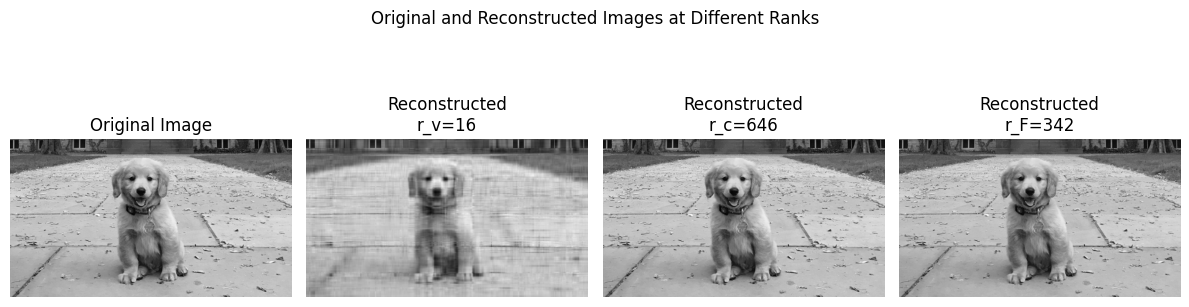

In [ ]:
import matplotlib.pyplot as plt

# Assuming X, X_rv, X_rc, X_rF are all (32, 32) arrays (2D images)

plt.figure(figsize=(12, 4))

plt.subplot(1, 4, 1)
plt.imshow(X, cmap="gray")
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(X_rv, cmap="gray")
plt.title(f"Reconstructed\nr_v={rv}")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(X_rc, cmap="gray")
plt.title(f"Reconstructed\nr_c={rc}")
plt.axis("off")

if rF is not None:
    plt.subplot(1, 4, 4)
    plt.imshow(X_rF, cmap="gray")
    plt.title(f"Reconstructed\nr_F={rF}")
    plt.axis("off")

plt.suptitle("Original and Reconstructed Images at Different Ranks")
plt.tight_layout()
plt.show()


# Exercise 2


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import jax.scipy.linalg

Consider the function

$$
f(x,y) = 100(y-x^2)^2 + (1-x)^2 \tag{2}
$$


In [ ]:
def f_manual(x, y):
    return 100 * (y - x**2) ** 2 + (1 - x) ** 2


def f_jax(xy):
    x, y = xy[0], xy[1]
    return 100 * (y - x**2) ** 2 + (1 - x) ** 2

Compute the gradient $\nabla f$ and the Hessian $D^2 f$ of (2). Prove that the function has a unique minimizer $x^*$ and find the minimizer.


Gradient

$$
\nabla f = \begin{bmatrix}
\frac{\partial f}{\partial x} \\
\frac{\partial f}{\partial y}
\end{bmatrix} =
\begin{bmatrix}
-400x(y - x^2) + 2(x - 1) \\
200(y - x^2)
\end{bmatrix}
$$

Hessian $D^2 f$

$$
D^2 f = \begin{bmatrix}
\frac{\partial^2 f}{\partial x^2} & \frac{\partial^2 f}{\partial x \partial y} \\
\frac{\partial^2 f}{\partial y \partial x} & \frac{\partial^2 f}{\partial y^2}
\end{bmatrix} =
\begin{bmatrix}
-400(y - x^2) + 800x^2 + 2 & -400x \\
-400x & 200
\end{bmatrix}
$$

**Minimizer $\mathbf{x}^*$**

Set the gradient to zero:

$$
\begin{cases}
-400x(y - x^2) + 2(x - 1) = 0 \\
200(y - x^2) = 0
\end{cases}
$$

From the second equation:

$$
y = x^2
$$

Substitute into the first:

$$
2(x - 1) = 0 \implies x = 1
$$

Therefore:

$$
\boxed{
x^* = 1, \quad y^* = 1
}
$$

**Uniqueness and Verification**

Evaluate the Hessian at $(1,1)$:

$$
D^2 f(1,1) = \begin{bmatrix}
802 & -400 \\
-400 & 200
\end{bmatrix}
$$

Check positive definiteness:

- Leading principal minor: $802 > 0$
- Determinant: $802 \times 200 - (-400)^2 = 160400 - 160000 = 400 > 0$

Since the Hessian is positive definite at $(1,1)$, the critical point is a strict local minimizer.

Because $f$ is a sum of squares and continuous, this local minimizer is the unique global minimizer.


In [ ]:
# Manual gradient (two separate inputs)
def grad_f_manual(x, y):
    df_dx = -400 * x * (y - x**2) + 2 * (x - 1)
    df_dy = 200 * (y - x**2)
    return np.array([df_dx, df_dy])


# Manual Hessian (two separate inputs)
def hessian_f_manual(x, y):
    d2f_dx2 = -400 * (y - x**2) + 800 * x**2 + 2
    d2f_dxdy = -400 * x
    d2f_dydx = -400 * x
    d2f_dy2 = 200
    return np.array([[d2f_dx2, d2f_dxdy], [d2f_dydx, d2f_dy2]])


# JAX gradient and Hessian
grad_f_jax = jax.grad(f_jax)
hessian_f_jax = jax.hessian(f_jax)

In [ ]:
# Evaluate at the minimum (1,1)
x_min, y_min = 1.0, 1.0
xy_min = jnp.array([x_min, y_min])

# Manual results
grad_manual = grad_f_manual(x_min, y_min)
hess_manual = hessian_f_manual(x_min, y_min)

# JAX results
grad_jax = grad_f_jax(xy_min)
hess_jax = hessian_f_jax(xy_min)

# Print comparison
print("At minimum (1,1):")
print("Manual Gradient:", grad_manual)
print(
    "JAX Gradient:", np.array(grad_jax)
)  # convert from DeviceArray to np array for clean print

print("\nManual Hessian:\n", hess_manual)
print("JAX Hessian:\n", np.array(hess_jax))

At minimum (1,1):
Manual Gradient: [0. 0.]
JAX Gradient: [0. 0.]

Manual Hessian:
 [[ 802. -400.]
 [-400.  200.]]
JAX Hessian:
 [[ 802. -400.]
 [-400.  200.]]


Implement the Gradient Descent algorithm with constant stepsize to approximate the minimizer. The code must take as input the following parameters

`max_iter = 50000 # maximum number of iterations`

`tol = 1e-8 # tolerance for the stopping criterium`

`x_0 = np.array([-1.2,1.2]) # initial guess`

`stepsize = 0.001 # constant stepsize`

`func = see equation (2) # the expression of the function to be minimized`

`dfunc = gradient of equation (2) # the expression of the gradient of the function to be minimized`

Use the following expression for stopping criterium

$$
\epsilon^{(k)} = |f(x^{(k)}, y^{(k)}) - f(x^{(k-1)}, y^{(k-1)})| \tag{3}
$$


In [ ]:
def gradient_descent_jax(
    x0,
    func,
    grad_func,
    max_iter=50000,
    tol=1e-8,
    stepsize=0.001,
    tol_func=1e-8,
):
    x_old = x0
    f_old = func(x_old)
    history = [x_old]
    f_values = [f_old]

    for k in range(1, max_iter + 1):
        grad_val = grad_func(x_old)
        d = -grad_val
        x_new = x_old + stepsize * d
        f_new = func(x_new)

        # Stopping criterion
        if jnp.abs(f_new - f_old) < tol_func or f_new < tol_func:
            print(f"Stopping at iteration {k} due to function change tolerance.")
            break

        x_old, f_old = x_new, f_new
        history.append(x_new)
        f_values.append(f_new)

    return x_new, f_new, history, f_values


# Initial guess
x0 = jnp.array([-1.2, 1.2])

# Run gradient descent using JAX functions
x_min, f_min, hist, f_vals = gradient_descent_jax(x0, f_jax, jax.jit(grad_f_jax))

print("Approximate minimizer:", x_min)
print("Function value at minimizer:", f_min)

Stopping at iteration 12018 due to function change tolerance.
Approximate minimizer: [0.99646014 0.9929186 ]
Function value at minimizer: 1.2550735e-05


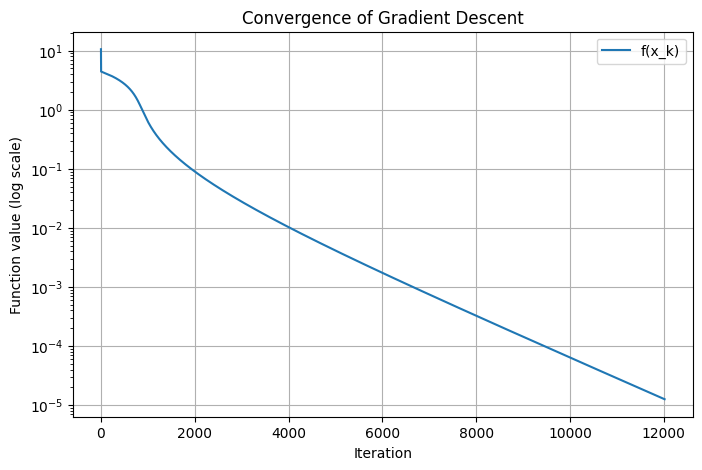

In [ ]:
# Plot convergence curve
plt.figure(figsize=(8, 5))
plt.plot(f_vals, label="f(x_k)")
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Function value (log scale)")
plt.title("Convergence of Gradient Descent")
plt.grid(True)
plt.legend()
plt.show()

Consider the following matrix

$$
f = \begin{bmatrix}
802 & -300 \\
-400 & 200
\end{bmatrix}
$$

Compute the eigenvalues of H and decide if it is positive-definite or not. Towards the end of the algorithm (when you are close to the minimum) replace the descent direction $d= -\nabla f(x)$ with $d=-H^{-1} \nabla f(x)$. Is this still a descent direction ? What behaviour do you observe? Can you explain this behaviour ?


In [ ]:
# Define the function only
def f(x):
    return 100 * (x[1] - x[0] ** 2) ** 2 + (1 - x[0]) ** 2


# Use JAX to get grad and hessian automatically
grad_f_jit = jax.jit(jax.grad(f))
hess_f_jit = jax.jit(jax.hessian(f))
f_jax = jax.jit(f)


# Gradient Descent with Newton Switch
def gradient_descent_newton_switch(
    x0,
    func,
    grad_func,
    hess_func,
    max_iter=50000,
    tol=1e-8,
    stepsize=0.001,
    tol_func=1e-8,
    tol_switch=1e-3,
):
    x_old = x0
    f_old = func(x_old)
    history = [x_old]

    for k in range(1, max_iter + 1):
        grad = grad_func(x_old)
        grad_norm = jnp.linalg.norm(grad)
        eps_k = jnp.abs(f_old - func(x_old))

        close_to_min = (grad_norm < tol_switch) or (eps_k < tol_switch)

        if close_to_min:
            H = hess_func(x_old)
            L = jnp.linalg.cholesky(H)
            y = jax.scipy.linalg.solve_triangular(L, grad, lower=True)
            d = -jax.scipy.linalg.solve_triangular(L.T, y, lower=False)
        else:
            d = -grad

        x_new = x_old + stepsize * d
        f_new = func(x_new)

        history.append(x_new)

        if jnp.abs(f_new - f_old) < tol_func or f_new < tol_func:
            print(f"Stopping at iteration {k} due to function change tolerance.")
            break

        x_old, f_old = x_new, f_new

    return x_new, f_new, history


# Initial guess and step size
x0 = jnp.array([-1.2, 1.2])
stepsize = 0.001

# Run optimization
x_star, f_star, history = gradient_descent_newton_switch(
    x0,
    f_jax,
    grad_f_jit,
    hess_f_jit,
    max_iter=50000,
    tol_func=1e-8,
    stepsize=stepsize,
    tol_switch=1e-5,
)

print("Found minimizer:", x_star)
print("Function value at minimizer:", f_star)

Stopping at iteration 10860 due to function change tolerance.
Found minimizer: [0.9977666  0.99553233]
Function value at minimizer: 4.991473e-06


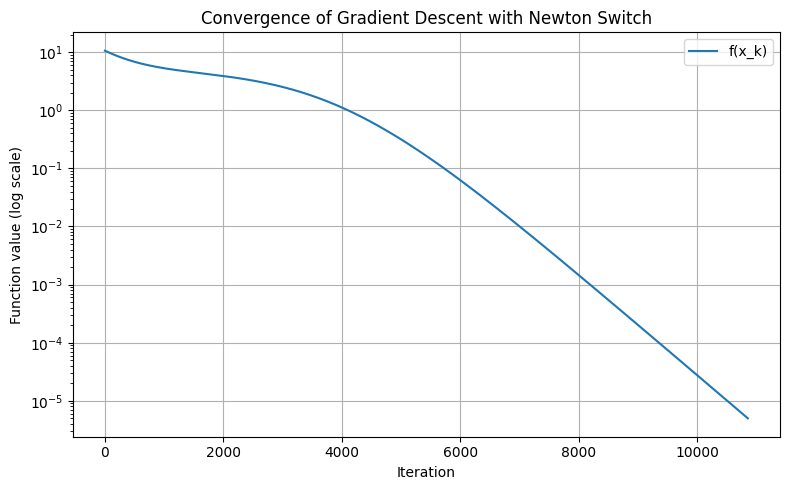

In [ ]:
# Plot convergence
f_values = [f_jax(x) for x in history]

plt.figure(figsize=(8, 5))
plt.plot(f_values, label="f(x_k)")
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Function value (log scale)")
plt.title("Convergence of Gradient Descent with Newton Switch")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

The matrix $H$ here is the Hessian evaluated near the minimum. Since eigenvalues are positive, $H$ is positive definite.

Thus, the Newton step $d = −H^{-1} \nabla f(x)$ is a descent direction because $𝐻$ is positive definite.

Near the minimum, Newton steps typically allow faster (quadratic) convergence compared to gradient descent.

Using a fixed step size with Newton steps can sometimes cause overshooting or instability, so in practice, line search or trust region methods are used.

If $H$ were not positive definite, Newton steps could fail to be descent directions and cause divergence.
